# Import required packages

In [2]:
from Bio import AlignIO
from Bio.Align.Applications import ClustalOmegaCommandline
from Bio.Phylo.TreeConstruction import DistanceCalculator, DistanceTreeConstructor
from Bio.Phylo import draw
from Bio import SeqIO
from Bio import Phylo, AlignIO
import subprocess
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from Bio.Align.Applications import ClustalOmegaCommandline

# Data

In [3]:
os.listdir('sequences/') #fasta files to import

['cov_Rhinolophus.fasta',
 'cov_mers.fasta',
 'cov_anatidae.fasta',
 'multiple_cov_align.fasta',
 'cov_apodemus.fasta',
 'cov_manis.fasta',
 'cov_sapiens.fasta',
 'all.fasta',
 'cov_gallus.fasta',
 'aligned.fasta']

###  Genomes of the Coronaviridae familly from different host species: 

-------------------------------------------------
| Code:      | host:              |             |
|------------|--------------------|-------------|
| MN996528   |  Homo Sapiens      | SARS-CoV-2  |
|            |                    |             |
| NC_019843  |  Homo Sapiens      | MERS-CoV    |
|            |                    |             |
| JQ065048   |  Anatidae          |             |
|            |                    |             |
| MG772934   | Rhinolophus        |             |
|            |                    |             |
| NC_034972  | Apodemus chevrieri |             |
|            |                    |             |
| KX38909    | Gallus gallus      |             |
|            |                    |             |
| MT084071   | Manis javanica     |             |
|            |                    |             |


*The data can be downloaded here:* https://www.ncbi.nlm.nih.gov/labs/virus/vssi/

In [4]:
gallus = SeqIO.read("sequences/cov_gallus.fasta", "fasta") #Chicken
covid19 = SeqIO.read("sequences/cov_sapiens.fasta", "fasta") #H. Sapiens Covid-19
rhinolophus = SeqIO.read("sequences/cov_Rhinolophus.fasta", "fasta") #Bat
anatidae = SeqIO.read("sequences/cov_anatidae.fasta", "fasta")# Duck/swan
mers = SeqIO.read('sequences/cov_mers.fasta', 'fasta') # H. Sapiens MERS
apodemus = SeqIO.read('sequences/cov_apodemus.fasta', 'fasta') #Apodemus chevrieri
manis=SeqIO.read('sequences/cov_manis.fasta', 'fasta')#Manis javanica

list_rec=[gallus, covid19, rhinolophus, anatidae, mers, apodemus, manis]

In [5]:
#reads = SeqIO.parse(file,"fasta")
end = []

for record in list_rec:
    #record[:n].append(end)
    end.append(record)
    
SeqIO.write(end, "sequences/all.fasta", "fasta")

7

# Multiple Sequence Alignement

The alignment was performed using the command line tool Clustal omega.

In [6]:
# Define input file
in_file = "sequences/all.fasta"

# Define output file
out_file = "sequences/aligned.fasta"

# Get the command for Clustal Omega
clustalomega_cline = ClustalOmegaCommandline(infile=in_file, outfile=out_file, verbose=True, auto=True)

# Print the executable command
print(clustalomega_cline)

clustalo -i sequences/all.fasta -o sequences/aligned.fasta --auto -v


In [12]:
!clustalo -i sequences/all.fasta -o sequences/aligned.fasta --auto -v

In [16]:
align = AlignIO.read("sequences/aligned.fasta", "fasta")
print(align)

SingleLetterAlphabet() alignment with 7 rows and 33063 columns
--------------------------------------------...--- KX389094
--------------------------------------------...--- JQ065048
--------------------------------------------...--- NC_019843
--------------------------------------------...--- MN996528
--------------------------------------------...AAA MG772934
AGAAACAAGTAGTGTTTTAAAAACCTTCAAATTAGTGCCTGTAA...--- NC_034972
--------------------------------------------...--- MT084071


# Distance calculation

The distance calculator of the TreeConstruction Biopython package is used here.

In [17]:
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(align)

# Create the Phylogenetic Tree


Distance Matrix:
-----------------------
KX389094	0
JQ065048	0.4881287239512446	0
NC_019843	0.584853159120467	0.6193025436288297	0
MN996528	0.5639839095060944	0.6044218612951033	0.489610743126758	0
MG772934	0.5663127967819013	0.6074161449354263	0.4941475365211868	0.11414572180382909	0
NC_034972	0.6187581284214984	0.6322777727368962	0.5997943320327859	0.5639536642167982	0.5639839095060944	0
MT084071	0.586274687717388	0.6130720140338142	0.5378822248434807	0.21610259202129267	0.24084323866557789	0.502827934549194	0
	KX389094	JQ065048	NC_019843	MN996528	MG772934	NC_034972	MT084071

Phylogenetic Tree:
-----------------------
      ______________________________________________________________ NC_034972
     |
  ___|                                     _________________________ MT084071
 |   |      ______________________________|
 |   |     |                              |             ____________ MG772934
 |   |_____|                              |____________|
_|         |                

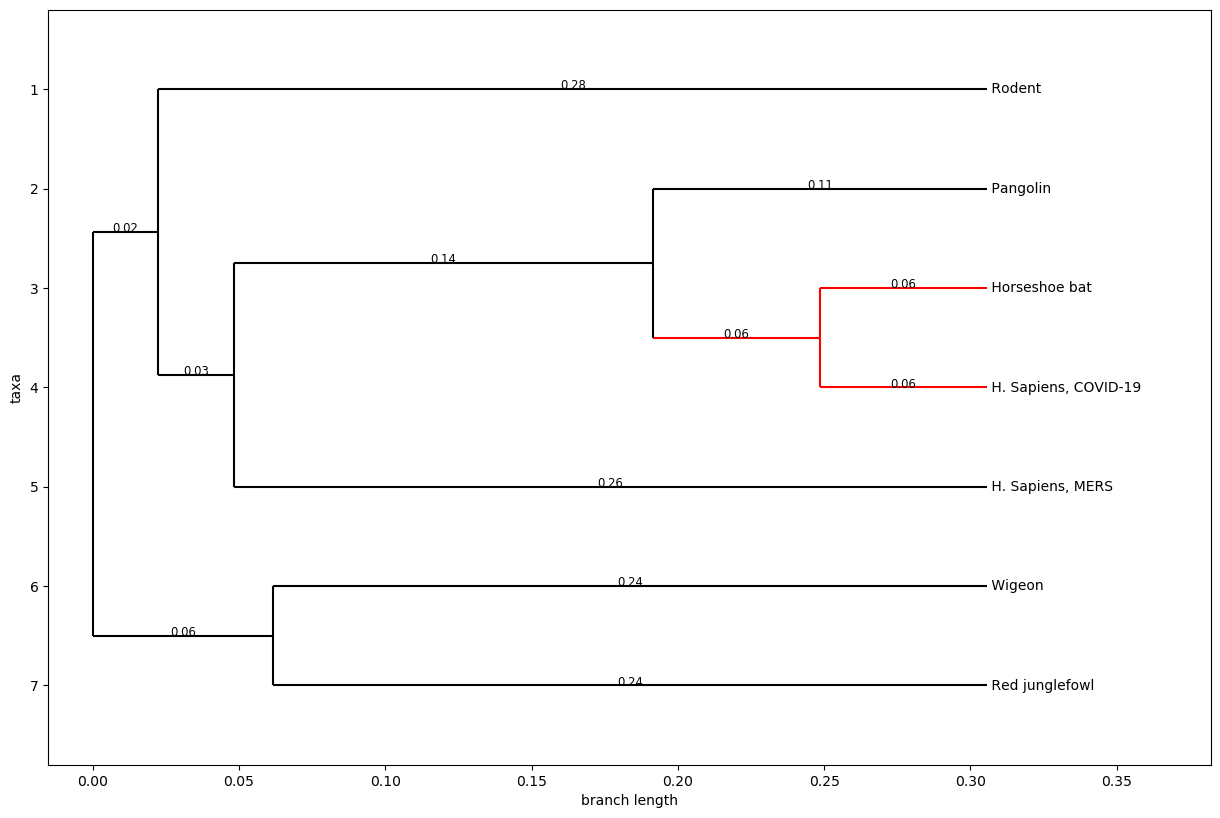

In [18]:
def get_label(leaf):
    code=['JQ065048', 'MN996528', 'NC_034972', 'NC_019843', 'KX389094', 'MG772934', 'MT084071']
    host=['Wigeon', 'H. Sapiens, COVID-19', 'Rodent', 'H. Sapiens, MERS', 'Red junglefowl', 'Horseshoe bat', 'Pangolin']
    
    if leaf.name.startswith('Inner'):
        name=''
        return name
    else:
        
        for i in range(0, len(code)):
            if leaf.name==code[i]:
                name=host[i]
                return name


print('\nDistance Matrix:\n-----------------------')
print(dm)

# Phylogenetic tree using UPGMA algorithm
constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm) # We color the human strain, SARS and SARS-CoV-2 in blue
#tree.clade[1, 1, 0].color = "black"
mrca = tree.common_ancestor({'name':  'MG772934'}, {'name': 'MN996528'})
mrca.color = "red"

fig = plt.figure(figsize=(15, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)
#Phylo.draw(tree, axes=axes, label_func=get_label)
Phylo.draw(tree, axes=axes, label_func=get_label, branch_labels=lambda c: round(c.branch_length, 2), do_show=False)
plt.savefig('phylogenetic_tree_origin_analysis.png')

print('\nPhylogenetic Tree:\n-----------------------')
Phylo.draw_ascii(tree)


# Comparison of SARS-CoV-2 sequences from different countries

The precalculated alignment of SARS-CoV-2 strains was directly downloaded from 
https://www.ncbi.nlm.nih.gov/labs/virus/vssi/.


In [19]:
from Bio import SeqIO
from Bio import AlignIO

align = AlignIO.read("sequences/multiple_cov_align.fasta", "fasta")

In [20]:
calculator = DistanceCalculator('identity')
dm = calculator.get_distance(align)

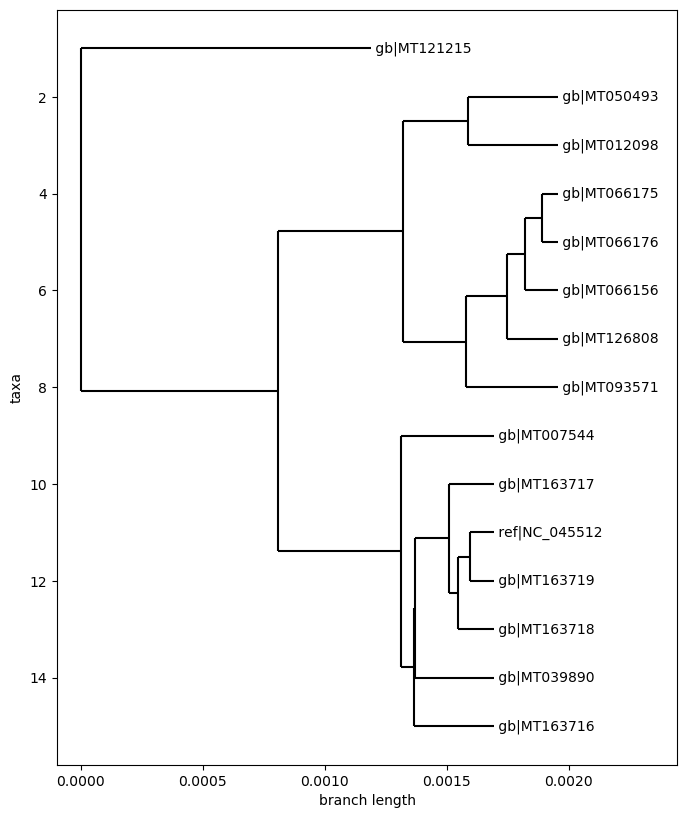

In [21]:
def get_label(leaf):
    if leaf.name.startswith('Inner'):
        name=''
    else:
        name=leaf.name

    return name

constructor = DistanceTreeConstructor()
tree = constructor.upgma(dm)

fig = plt.figure(figsize=(8, 10), dpi=100)
axes = fig.add_subplot(1, 1, 1)

#Phylo.draw(tree, axes=axes, do_show=False)
Phylo.draw(tree, axes=axes, label_func=get_label, branch_labels=lambda c: round(c.branch_length, 2), do_show=False)
plt.savefig('phylogenetic_tree_human_strains.png')
